In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import string
import secrets
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import Counter
import warnings
from warnings import filterwarnings

In [248]:
# Suppress warnings
filterwarnings("ignore")

In [249]:
# Function to generate a random password
def generate_password(length=12, use_lowercase=True, use_uppercase=True, use_digits=True, use_special_chars=True):
    characters = ""
    if use_lowercase:
        characters += string.ascii_lowercase
    if use_uppercase:
        characters += string.ascii_uppercase
    if use_digits:
        characters += string.digits
    if use_special_chars:
        characters += string.punctuation

    if not characters:
        raise ValueError("At least one character set must be selected")

    return ''.join(secrets.choice(characters) for _ in range(length))


In [250]:
# Function to calculate password entropy
def calculate_entropy(password):
    if not password:
        return 0
    char_set = 0
    if any(c in string.ascii_lowercase for c in password):
        char_set += 26
    if any(c in string.ascii_uppercase for c in password):
        char_set += 26
    if any(c in string.digits for c in password):
        char_set += 10
    if any(c in string.punctuation for c in password):
        char_set += len(string.punctuation)
    entropy = len(password) * math.log2(char_set)
    return entropy

In [251]:
# Load data
con = sqlite3.connect(r'/kaggle/input/password-datas/password_data.sqlite')
data = pd.read_sql_query("SELECT * FROM Users", con)


In [252]:
# Basic Data Cleaning
data.drop(["index"], axis=1, inplace=True)

In [253]:
# Feature Engineering
data["length"] = data["password"].str.len()
data["lowercase_freq"] = np.round(data["password"].apply(lambda x: len([char for char in x if char.islower()]) / len(x)), 3)
data["uppercase_freq"] = np.round(data["password"].apply(lambda x: len([char for char in x if char.isupper()]) / len(x)), 3)
data["digit_freq"] = np.round(data["password"].apply(lambda x: len([char for char in x if char.isdigit()]) / len(x)), 3)
data["special_char_freq"] = np.round(data["password"].apply(lambda x: len([char for char in x if not char.isalpha() and not char.isdigit()]) / len(x)), 3)
data["entropy"] = data["password"].apply(calculate_entropy)

In [254]:
# Visualize data
cols = ['length', 'lowercase_freq', 'uppercase_freq', 'digit_freq', 'special_char_freq', 'entropy']
for col in cols:
    print(col)
    print(data[[col, 'strength']].groupby(['strength']).agg(["min", "max", "mean", "median"]))
    print('\n')

length
         length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0


lowercase_freq
         lowercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.708050  0.714
1                   0.0  0.923  0.630067  0.667
2                   0.0  0.917  0.424679  0.400


uppercase_freq
         uppercase_freq                        
                    min    max      mean median
strength                                       
0                   0.0  1.000  0.012872  0.000
1                   0.0  0.923  0.007915  0.000
2                   0.0  0.889  0.367633  0.429


digit_freq
         digit_freq                        
                min    max      mean median
strength                                   
0   

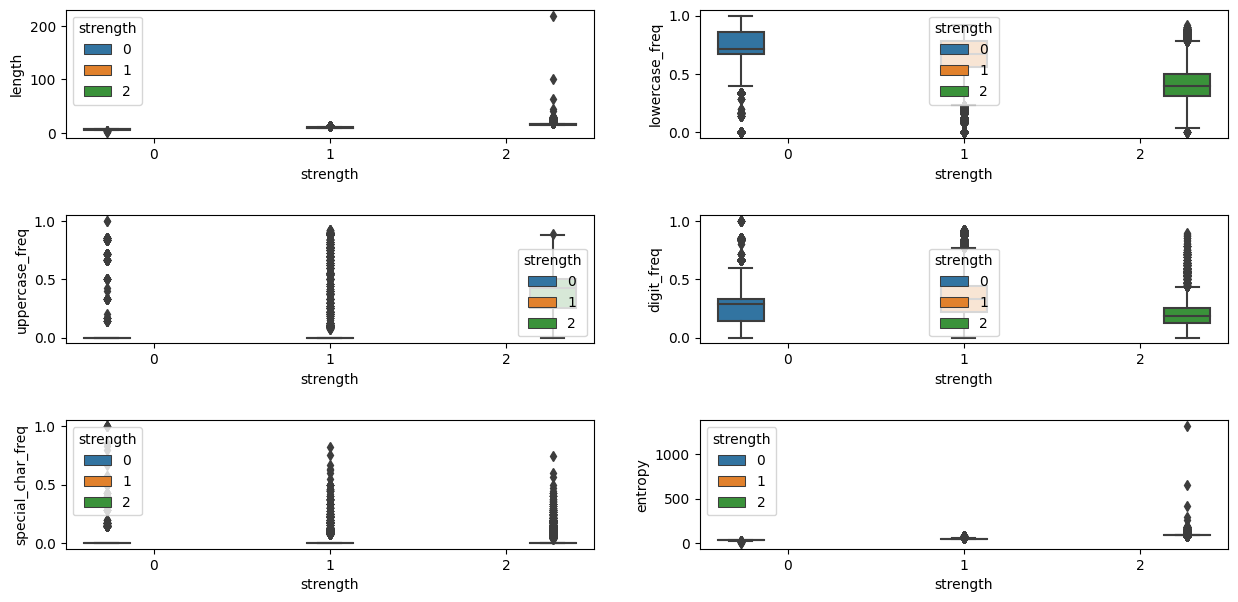

In [255]:
fig, axes = plt.subplots(3, 2, figsize=(15, 7))
sns.boxplot(x="strength", y='length', hue="strength", ax=axes[0, 0], data=data)
sns.boxplot(x="strength", y='lowercase_freq', hue="strength", ax=axes[0, 1], data=data)
sns.boxplot(x="strength", y='uppercase_freq', hue="strength", ax=axes[1, 0], data=data)
sns.boxplot(x="strength", y='digit_freq', hue="strength", ax=axes[1, 1], data=data)
sns.boxplot(x="strength", y='special_char_freq', hue="strength", ax=axes[2, 0], data=data)
sns.boxplot(x="strength", y='entropy', hue="strength", ax=axes[2, 1], data=data)
plt.subplots_adjust(hspace=0.6)

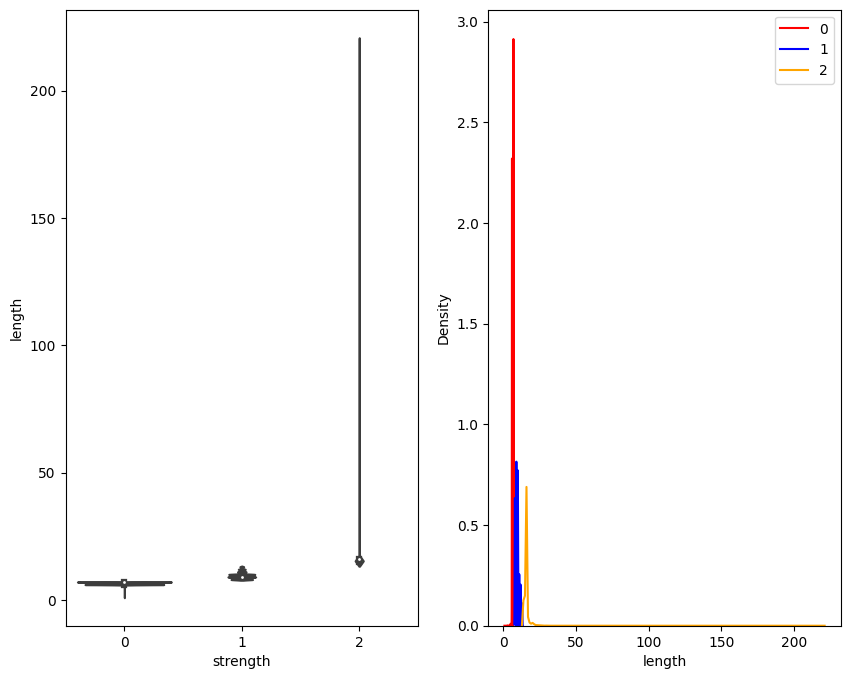

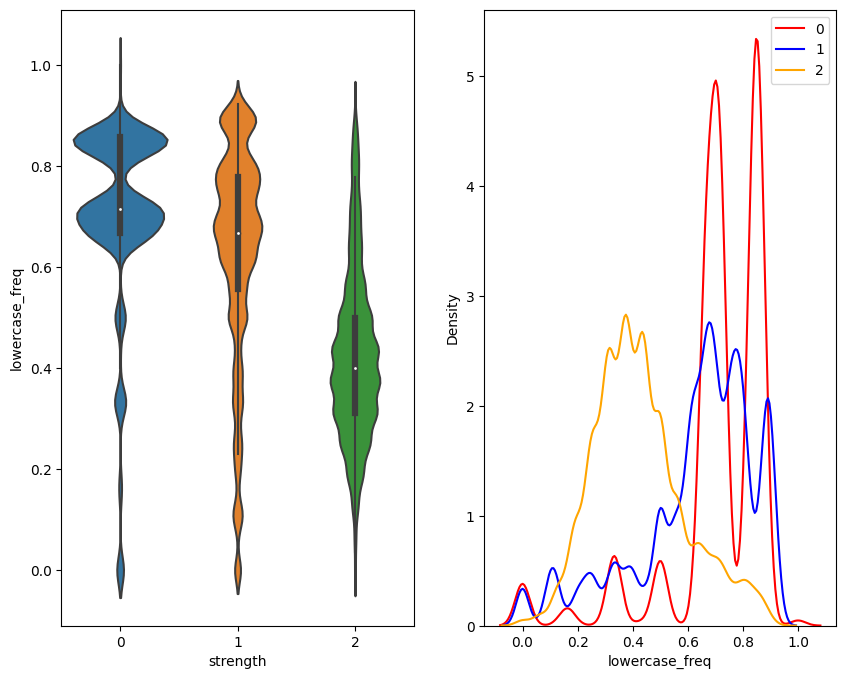

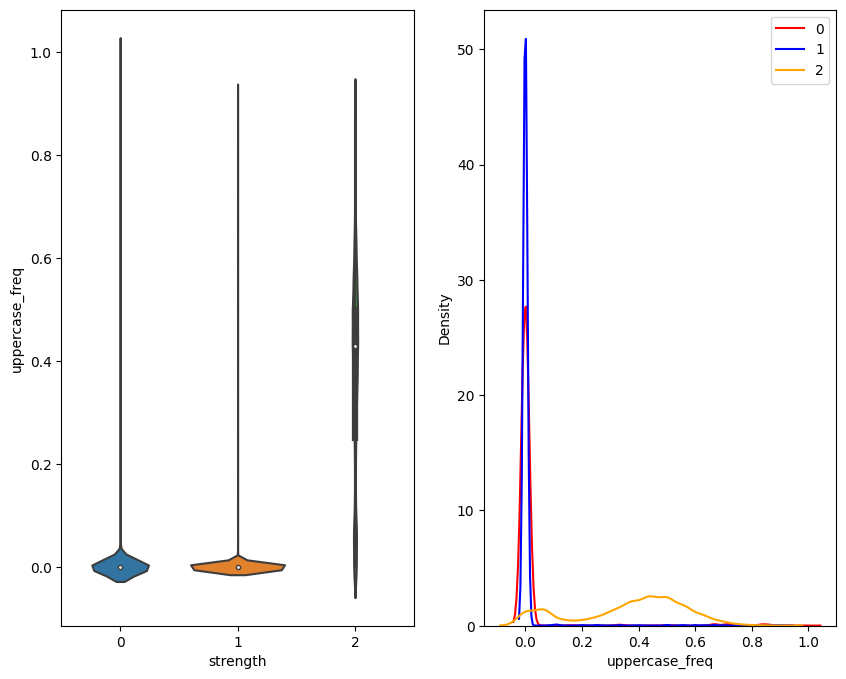

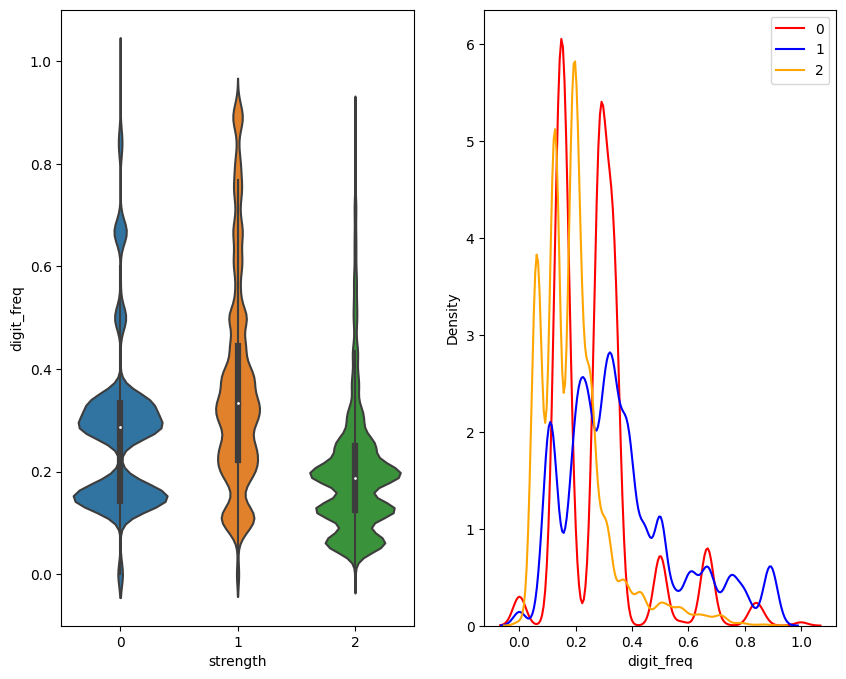

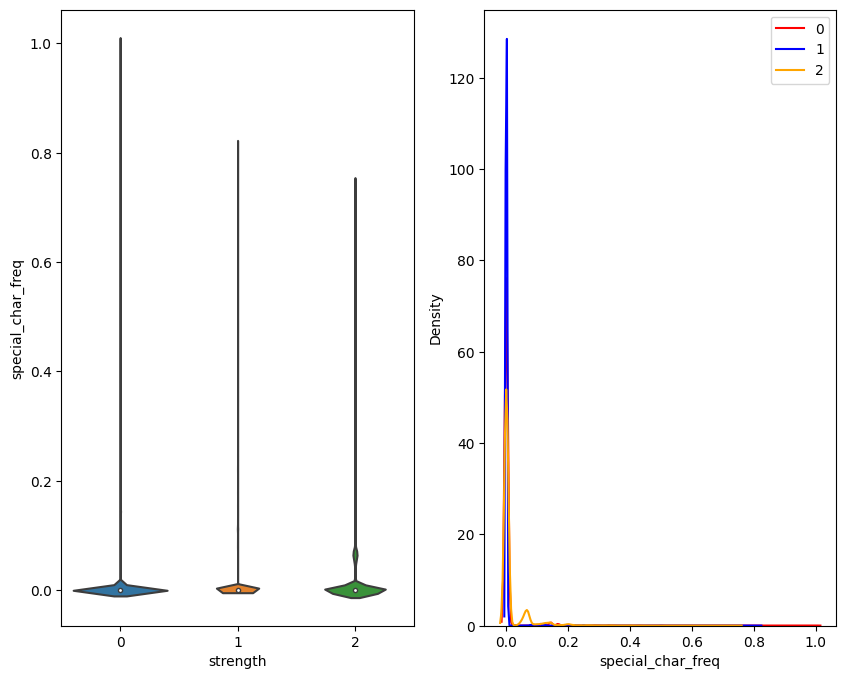

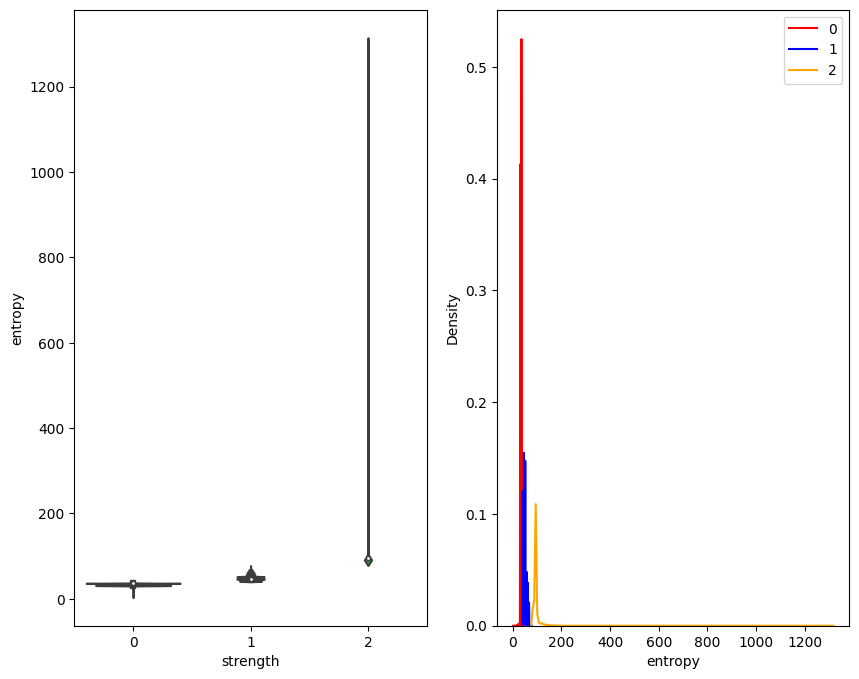

In [256]:
# Feature Importance
def get_dist(data, feature):
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    sns.violinplot(x='strength', y=feature, data=data)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data[data['strength'] == 0][feature], color="red", label="0")
    sns.kdeplot(data[data['strength'] == 1][feature], color="blue", label="1")
    sns.kdeplot(data[data['strength'] == 2][feature], color="orange", label="2")
    plt.legend()
    plt.show()
    
for col in cols:
    get_dist(data, col)

In [257]:
# Applying TF-IDF on data
dataframe = data.sample(frac=1)
x = list(dataframe["password"])
vectorizer = TfidfVectorizer(analyzer="char")
X = vectorizer.fit_transform(x)
df2 = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df2["length"] = dataframe['length']
df2["lowercase_freq"] = dataframe['lowercase_freq']
df2["entropy"] = dataframe['entropy']

In [258]:
# Machine Learning Algorithm
y = dataframe["strength"]
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.20)
clf = LogisticRegression(multi_class="multinomial")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(Counter(y_pred))


Counter({1: 17813, 2: 1718, 0: 469})


In [259]:
# Prediction on Sample Data
def predict(password=None):
    if password is None:
        password = input("Enter a password: ")
    
    # Debugging: Print the input password
    print(f"Input password: {password}")
    
    # Transform the password using the vectorizer
    sample_array = np.array([password])
    sample_matrix = vectorizer.transform(sample_array)
    
    # Calculate features
    length_pass = len(password)
    length_normalised_lowercase = len([char for char in password if char.islower()]) / len(password)
    entropy = calculate_entropy(password)
    
    # Append features to the TF-IDF matrix
    new_matrix2 = np.append(sample_matrix.toarray(), (length_pass, length_normalised_lowercase, entropy)).reshape(1, -1)
    
    # Debugging: Print the transformed input
    print(f"Transformed input: {new_matrix2}")
    
    # Predict the password strength
    result = clf.predict(new_matrix2)
    
    # Debugging: Print the prediction result
    print(f"Prediction result: {result}")
    
    if result == 0:
        return "Password is weak"
    elif result == 1:
        return "Password is normal"
    else:
        return "Password is strong"

# Ask the user if they want to generate a password
generate_option = input("Do you want to generate a password? (yes/no): ").strip().lower()

if generate_option == "yes":
    # Generate a password if the user says "yes"
    generated_password = generate_password()
    print("Generated Password:", generated_password)
    
    # Optionally, evaluate the generated password's strength
    print("Evaluating generated password strength...")
    print(predict(generated_password))  # Pass the generated password to the predict function
else:
    # If the user does not want to generate a password, proceed with manual input
    print("Skipping password generation.")
    print(predict())  # Evaluate the user's manually entered password

Do you want to generate a password? (yes/no):  no


Skipping password generation.


Enter a password:  dQ123ioPXvy!2@e


Input password: dQ123ioPXvy!2@e
Transformed input: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.53256049  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.13356096  0.30904711  0.17306705
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.4538269
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.19373428  0.15067736  0.
   0.          0.          0.15613888  0.          0.          0.
   0.          0.          0.15804891  0.21235712  0.24363063  0.
   0.          0.          0.          0.23248909  0.          0.24396377
   0.19875422  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  